In [86]:
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [87]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
ratings_df = pd.read_csv(ratings_file)

In [88]:
ratings_df.head()
ratings_df = ratings_df.drop(['timestamp'], axis=1)

In [89]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [90]:
print(ratings_df.shape)
print(ratings_df['rating'].min())

(100836, 3)
0.5


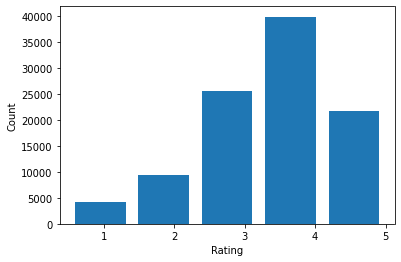

In [91]:
plt.hist(ratings_df['rating'], bins=5,rwidth=0.8)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


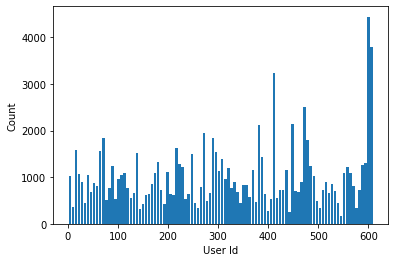

In [92]:
plt.hist(ratings_df['userId'], bins=100,rwidth=0.8)
plt.xlabel('User Id')
plt.ylabel('Count')
plt.show()

In [93]:
train_df, val_df = train_test_split(ratings_df,test_size=0.2)
train_df = train_df.reset_index()[['userId','movieId','rating']]
val_df = val_df.reset_index()[['userId','movieId','rating']]

In [94]:
def encode_field(data):
    keys = data.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys) }
    return key_to_id, np.array([key_to_id[i] for i in data]), len(keys)


In [95]:
def encode_dataframe(df):
    key_user_ids, df['userId'],num_user = encode_field(df['userId'])
    key_movie_ids, df['movieId'], num_movie = encode_field(df['movieId'])
    return df, key_user_ids, key_movie_ids, num_user, num_movie
    

In [96]:
movie_df, user_ids, movie_ids, num_user, num_movie = encode_dataframe(train_df)
print(num_user,num_movie)
print(ratings_df.shape)

610 9004
(100836, 3)


In [97]:
def sparse_matrix(df,num_rows,num_cols,column='rating'):
    return csc_matrix((df[column].values,(df['userId'].values,df['movieId'].values)),shape = (num_rows,num_cols))

In [98]:
def create_embedding_matrix(rows,cols):
    return 5*np.random.random((rows,cols))/cols

In [99]:
Y = sparse_matrix(movie_df,num_user,num_movie)

In [100]:
lmbda = 0.0002
def predict(df,embed_user,embed_movie):
    df['prediction'] = np.sum(np.multiply(embed_movie[df['movieId']],embed_user[df['userId']]),axis=1)
    return df

In [101]:
def cost(df,embed_user,embed_movie):
    Y = sparse_matrix(df,embed_user.shape[0],embed_movie.shape[0])
    prediction = sparse_matrix(predict(df,embed_user,embed_movie),embed_user.shape[0],embed_movie.shape[0],column = 'prediction')
    return np.sum((Y-prediction).power(2))/df.shape[0]

In [102]:
embed_user = create_embedding_matrix(num_user,3)
embed_anime = create_embedding_matrix(num_movie,3)
predict(movie_df,embed_user,embed_anime)
cost(movie_df,embed_user,embed_anime)

4.236668068031279

In [103]:
def gradient(df ,embed_user,embed_movie):
    predicted = sparse_matrix(predict(df, embed_user, embed_movie), embed_user.shape[0], embed_movie.shape[0], 'prediction')
    Y = sparse_matrix(df,embed_user.shape[0],embed_movie.shape[0])
    delta = Y - predicted
    grad_user = (-2/df.shape[0])*(delta*embed_movie) + 2*lmbda*embed_user
    grad_movie = (-2/df.shape[0])*(delta.T*embed_user) + 2*lmbda*embed_movie
    return grad_user, grad_movie

In [104]:
def gradient_descent(df, embed_user, embed_movie, iterations=2000, learning_rate=0.01, df_val=None):

    beta = 0.9
    Y = sparse_matrix(df,embed_user.shape[0],embed_movie.shape[0])
    grad_user, grad_movie = gradient(df, embed_user, embed_movie)
    v_user = grad_user
    v_movie = grad_movie
    for i in range(iterations):
        grad_user, grad_movie = gradient(df, embed_user, embed_movie)
        v_user = beta*v_user + (1-beta)*grad_user
        v_movie = beta*v_movie + (1-beta)*grad_movie
        embed_user = embed_user - learning_rate*v_user
        embed_movie = embed_movie - learning_rate*v_movie
        if(not (i+1)%50):
            print("\niteration", i+1, ":")
            print("train mse:",  cost(df, embed_user, embed_movie))
            if df_val is not None:
                print("validation mse:",  cost(df_val, embed_user, embed_movie))
    return embed_user, embed_movie

In [105]:
emb_user = create_embedding_matrix(num_user, 4)
emb_movie = create_embedding_matrix(num_movie, 4)
emb_user, emb_movie = gradient_descent(movie_df, emb_user, emb_movie, iterations=2000, learning_rate=0.5)



iteration 50 :
train mse: 3.350611414726433

iteration 100 :
train mse: 2.5811647657121504

iteration 150 :
train mse: 2.1625329461438993

iteration 200 :
train mse: 1.9065550069017896

iteration 250 :
train mse: 1.7348749219023745

iteration 300 :
train mse: 1.6112412459901149

iteration 350 :
train mse: 1.5175660410833707

iteration 400 :
train mse: 1.4439877678908644

iteration 450 :
train mse: 1.3846480118784654

iteration 500 :
train mse: 1.3358127310559442

iteration 550 :
train mse: 1.2949708288903388

iteration 600 :
train mse: 1.26036352574761

iteration 650 :
train mse: 1.2307191722901398

iteration 700 :
train mse: 1.2050942812534478

iteration 750 :
train mse: 1.1827735044811114

iteration 800 :
train mse: 1.1632042553164386

iteration 850 :
train mse: 1.1459526429281044

iteration 900 :
train mse: 1.1306730026911969

iteration 950 :
train mse: 1.117086362385375

iteration 1000 :
train mse: 1.1049649300943623

iteration 1050 :
train mse: 1.0941207284201169

iteration 1100 

In [106]:
def encode_new_data(val_df,key_user_ids, key_movie_ids):
    val_index = val_df['movieId'].isin(key_movie_ids.keys()) & val_df['userId'].isin(key_user_ids.keys())
    val_df = val_df[val_index]
    val_df['movieId'] = np.array([key_movie_ids[i] for i in val_df['movieId']])
    val_df['userId'] = np.array([key_user_ids[i] for i in val_df['userId']])
    return val_df

In [107]:
print(val_df.shape)
val_df_encoded = encode_new_data(val_df,user_ids,movie_ids)
print(val_df_encoded.shape)

(20168, 3)
(19395, 3)


C:\Users\cheta\AppData\Local\Temp\ipykernel_23024\3317590743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['movieId'] = np.array([key_movie_ids[i] for i in val_df['movieId']])
C:\Users\cheta\AppData\Local\Temp\ipykernel_23024\3317590743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['userId'] = np.array([key_user_ids[i] for i in val_df['userId']])


In [108]:
train_mse = cost(train_df,emb_user,emb_movie)
val_mse = cost(val_df_encoded,emb_user,emb_movie)
print(train_mse,val_mse)

1.0110287066474501 1.1005134450230252


C:\Users\cheta\AppData\Local\Temp\ipykernel_23024\1519558760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'] = np.sum(np.multiply(embed_movie[df['movieId']],embed_user[df['userId']]),axis=1)


# Neural Net Model

In [109]:
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

In [110]:
ratings_df[10:20]
user_ids = ratings_df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings_df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings_df["user"] = ratings_df["userId"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movieId"].map(movie2movie_encoded)


In [111]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
ratings_df["rating"] = ratings_df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings_df["rating"])
max_rating = max(ratings_df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [112]:
train_df, val_df = train_test_split(ratings_df,test_size=0.1)

In [113]:
print(ratings_df.shape, train_df.shape, val_df.shape)
x_train = train_df[["user", "movie"]].values
y_train = train_df["rating"].values
x_val = val_df[["user", "movie"]].values
y_val = val_df["rating"].values
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(100836, 5) (90752, 5) (10084, 5)
(90752, 2) (90752,) (10084, 2) (10084,)


In [114]:
class Recommender(keras.Model):
    def __init__(self,num_users,num_movies,embedding_size,**kwargs):
        super(Recommender,self).__init__(**kwargs)
        
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.input_layer = layers.Input(shape=[1])
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_flatten = layers.Flatten()
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        
        self.movie_flatten = layers.Flatten()
        self.dot_layer = layers.Dot(axes=1)
        self.dense_layer1 = layers.Dense(150,activation="relu",kernel_initializer="he_normal")
        self.dense_layer2 = layers.Dense(50,activation="relu",kernel_initializer="he_normal")
        self.dense_layer3 = layers.Dense(1,activation="relu")
        
    
    def call(self,inputs):
        
        user_vector = self.user_embedding(inputs[:,0])
        user_vector = self.user_flatten(user_vector)
        movie_vector = self.movie_embedding(inputs[:,1])
        movie_vector = self.movie_flatten(movie_vector)
        dot = self.dot_layer([user_vector,movie_vector])
        x = self.dense_layer1(dot)
        x = self.dense_layer2(x)
        x = self.dense_layer3(x)
        return x




In [131]:
model = Recommender(num_users,num_movies,50)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss=keras.losses.MeanSquaredError(),
)
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 9s 6ms/step - loss: 3.4795 - val_loss: 1.6743
Epoch 2/5
1418/1418 [==============================] - 9s 6ms/step - loss: 1.4428 - val_loss: 1.2550
Epoch 3/5
1418/1418 [==============================] - 9s 6ms/step - loss: 1.2093 - val_loss: 1.1332
Epoch 4/5
1418/1418 [==============================] - 10s 7ms/step - loss: 1.1383 - val_loss: 1.1036
Epoch 5/5
1418/1418 [==============================] - 9s 6ms/step - loss: 1.1163 - val_loss: 1.0822


In [116]:
model.summary()


Model: "recommender_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  30500     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 embedding_3 (Embedding)     multiple                  486200    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dot_1 (Dot)                 multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  300       
                                                                 
 dense_4 (Dense)             multiple                

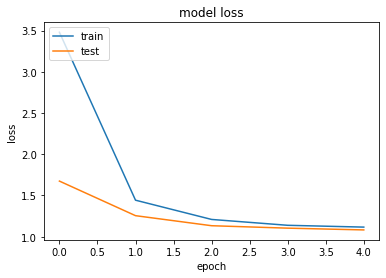

In [132]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [118]:
movie_df = pd.read_csv(movielens_dir /"movies.csv")
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [119]:
ratings_df.head()

,userId,movieId,rating,user,movie
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4


In [120]:
user_id = ratings_df.userId.sample(1).iloc[0]
movies_watched_by_user = ratings_df[ratings_df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)
]['movieId']
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]


282/282 [==============================] - 1s 2ms/step


In [121]:
# print(user_movie_array.shape,len(movies_not_watched))
# print(user_movie_array)
# print(movies_not_watched)
# print(ratings.argsort())
# print(movies_not_watched[])
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df['movieId'].isin(top_movies_user)]
# print(movie_df_rows)
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)
    


Showing recommendations for user: 19
Movies with high ratings from user
--------------------------------
Nightmare Before Christmas, The (1993) : Animation|Children|Fantasy|Musical
Rear Window (1954) : Mystery|Thriller
Maltese Falcon, The (1941) : Film-Noir|Mystery
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Ferris Bueller's Day Off (1986) : Comedy
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Paths of Glory (1957) : Drama|War
Seven Samurai (Shichinin no samurai) (1954) : Action|Adventure|Drama
Yojimbo (1961) : Action|Adventure
Memento (2000) : Mystery|Thriller
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Kill Bill: Vol. 1 (2003) : Action|Crime|Thriller
Inglourious Basterds (2009) : Action|Drama|War
